# Task 1: Understanding the Limitations of RNNs and the Need for Transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [ ]:
max_features = 30000
maxlen       = 200

(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=max_features)
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test  = keras.preprocessing.sequence.pad_sequences(x_test,  maxlen=maxlen)

print("Train shape:", x_train.shape, "Labels:", y_train.shape)
print("Test  shape:", x_test.shape,  "Labels:", y_test.shape)

rnn_model = keras.Sequential([
    layers.Embedding(max_features, 128, input_length=maxlen),
    layers.SimpleRNN(64),
    layers.Dense(1, activation='sigmoid')
])

rnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

rnn_history = rnn_model.fit(
    x_train, y_train,
    epochs=3,
    batch_size=64,
    validation_split=0.2
)

loss, acc = rnn_model.evaluate(x_test, y_test, batch_size=64)
print(f"\nTest Loss    : {loss:.4f}")
print(f"Test Accuracy: {acc:.4%}")

Train shape: (25000, 200) Labels: (25000,)
Test  shape: (25000, 200) Labels: (25000,)
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.6176 - loss: 0.6403 - val_accuracy: 0.7580 - val_loss: 0.5043
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8588 - loss: 0.3363 - val_accuracy: 0.7608 - val_loss: 0.5188
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9573 - loss: 0.1342 - val_accuracy: 0.8076 - val_loss: 0.5203
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7980 - loss: 0.5509

Test Loss    : 0.5437
Test Accuracy: 80.1720%


In [ ]:
y_pred_prob = rnn_model.predict(x_test, batch_size=64)
y_pred      = (y_pred_prob >= 0.5).astype(int).flatten()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.83      0.81     12500
           1       0.82      0.77      0.80     12500

    accuracy                           0.80     25000
   macro avg       0.80      0.80      0.80     25000
weighted avg       0.80      0.80      0.80     25000



In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim)]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

embed_dim = 32
num_heads = 2
ff_dim = 32

inputs = layers.Input(shape=(maxlen,))
embedding_layer = layers.Embedding(max_features, embed_dim)(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)(embedding_layer, training=False)
global_avg_pooling = layers.GlobalAveragePooling1D()(transformer_block)
dropout = layers.Dropout(0.1)(global_avg_pooling)
outputs = layers.Dense(1, activation="sigmoid")(dropout)

transformer_model = keras.Model(inputs=inputs, outputs=outputs)
transformer_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
transformer_history = transformer_model.fit(x_train, y_train, epochs=3, batch_size=64, validation_split=0.2)

transformer_test_loss, transformer_test_acc = transformer_model.evaluate(x_test, y_test)
print(f"\nTransformer Test accuracy: {transformer_test_acc:.4f}")


Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.7131 - loss: 0.5491 - val_accuracy: 0.8800 - val_loss: 0.2936
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9358 - loss: 0.1777 - val_accuracy: 0.8800 - val_loss: 0.2956
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9684 - loss: 0.0932 - val_accuracy: 0.8776 - val_loss: 0.3994
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8558 - loss: 0.4601

Transformer Test accuracy: 0.8545


In [ ]:
y_pred_prob = transformer_model.predict(x_test, batch_size=64)

# 2. Convert to binary labels at 0.5 threshold
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.86     12500
           1       0.86      0.84      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



# Task 2: Self-Attention Mechanism

Tokens: ['O', 'Captain!', 'my', 'Captain!', 'our', 'fearful', 'trip', 'is', 'done']
Attention weights matrix (rounded):
[[0.151 0.106 0.106 0.106 0.106 0.106 0.106 0.106 0.106]
 [0.102 0.145 0.102 0.145 0.102 0.102 0.102 0.102 0.102]
 [0.106 0.106 0.151 0.106 0.106 0.106 0.106 0.106 0.106]
 [0.102 0.145 0.102 0.145 0.102 0.102 0.102 0.102 0.102]
 [0.106 0.106 0.106 0.106 0.151 0.106 0.106 0.106 0.106]
 [0.106 0.106 0.106 0.106 0.106 0.151 0.106 0.106 0.106]
 [0.106 0.106 0.106 0.106 0.106 0.106 0.151 0.106 0.106]
 [0.106 0.106 0.106 0.106 0.106 0.106 0.106 0.151 0.106]
 [0.106 0.106 0.106 0.106 0.106 0.106 0.106 0.106 0.151]]


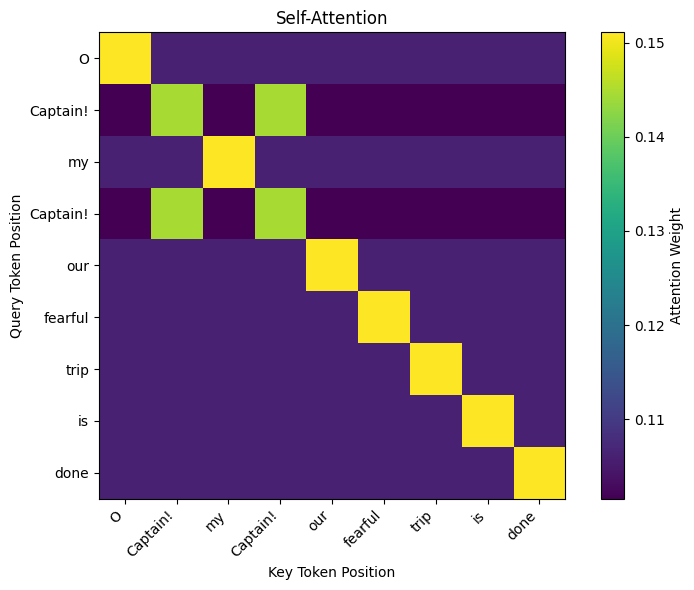

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def self_attention(X):
    d_k = X.shape[1]
    Q, K, V = X, X, X
    scores = np.dot(Q, K.T) / np.sqrt(d_k)
    exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
    weights = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    output = np.dot(weights, V)
    return output, weights

text = "O Captain! my Captain! our fearful trip is done"
tokens = text.split()

unique_tokens = ["O", "Captain!", "my", "our","fearful","trip","is","done"]
embed_map = {token: np.eye(len(unique_tokens))[i] for i, token in enumerate(unique_tokens)}
X = np.array([embed_map[t] for t in tokens])
output, weights = self_attention(X)

print("Tokens:", tokens)
print("Attention weights matrix (rounded):")
print(np.round(weights, 3))

plt.figure(figsize=(8, 6))
ww = plt.imshow(weights)
plt.title("Self-Attention")
plt.xlabel("Key Token Position")
plt.ylabel("Query Token Position")
plt.xticks(range(len(tokens)), tokens, rotation=45, ha='right')
plt.yticks(range(len(tokens)), tokens)
cbar = plt.colorbar(ww)
cbar.set_label('Attention Weight')
plt.tight_layout()
plt.show()


# Task 3: Introduction to Transformer Architecture

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

def scaled_dot_product_attention(q, k, v, mask=None):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_scores = matmul_qk / tf.math.sqrt(dk)
    if mask is not None:
        scaled_scores += (mask * -1e9)
    weights = tf.nn.softmax(scaled_scores, axis=-1)
    return tf.matmul(weights, v), weights

class MultiHeadAttention(layers.Layer):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.num_heads = num_heads
        self.depth = d_model // num_heads

        self.wq = layers.Dense(d_model)
        self.wk = layers.Dense(d_model)
        self.wv = layers.Dense(d_model)
        self.dense = layers.Dense(d_model)

    def split_heads(self, x):
        x = tf.reshape(x, (-1, tf.shape(x)[1], self.num_heads, self.depth))
        return tf.transpose(x, perm=[0,2,1,3])

    def call(self, q, k, v, mask=None):
        q = self.wq(q); k = self.wk(k); v = self.wv(v)
        q = self.split_heads(q)
        k = self.split_heads(k)
        v = self.split_heads(v)

        attn_out, attn_weights = scaled_dot_product_attention(q, k, v, mask)
        attn_out = tf.transpose(attn_out, perm=[0,2,1,3])
        concat = tf.reshape(attn_out, (-1, tf.shape(attn_out)[1], self.num_heads * self.depth))
        return self.dense(concat)

def get_positional_encoding(max_len, d_model):
    pos = np.arange(max_len)[:, np.newaxis]
    i   = np.arange(d_model)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2*(i//2)) / np.float32(d_model))
    angle_rads = pos * angle_rates
    pos_enc = np.zeros_like(angle_rads)
    pos_enc[:, 0::2] = np.sin(angle_rads[:, 0::2])
    pos_enc[:, 1::2] = np.cos(angle_rads[:, 1::2])
    return tf.cast(pos_enc[np.newaxis, ...], dtype=tf.float32)

class EncoderBlock(layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout_rate=0.1):
        super().__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = keras.Sequential([
            layers.Dense(d_ff, activation='relu'),
            layers.Dense(d_model)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, x, training, mask=None):
        attn_out = self.mha(x, x, x, mask)
        attn_out = self.dropout1(attn_out, training=training)
        out1 = self.layernorm1(x + attn_out)

        ffn_out = self.ffn(out1)
        ffn_out = self.dropout2(ffn_out, training=training)
        return self.layernorm2(out1 + ffn_out)

class TransformerClassifier(keras.Model):
    def __init__(self, num_layers, d_model, num_heads, d_ff, vocab_size,
                 max_len, num_classes, dropout_rate=0.1):
        super().__init__()
        self.token_emb = layers.Embedding(vocab_size, d_model)
        self.pos_enc = get_positional_encoding(max_len, d_model)
        self.enc_layers = [EncoderBlock(d_model, num_heads, d_ff, dropout_rate)
                           for _ in range(num_layers)]
        self.dropout = layers.Dropout(dropout_rate)
        self.global_pool = layers.GlobalAveragePooling1D()
        self.classifier = layers.Dense(num_classes, activation='softmax')

    def call(self, x, training):
        seq_len = tf.shape(x)[1]
        x = self.token_emb(x)
        x += self.pos_enc[:, :seq_len, :]
        x = self.dropout(x, training=training)

        for enc in self.enc_layers:
            x = enc(x, training=training)

        x = self.global_pool(x)
        return self.classifier(x)

max_words = 10000
max_len = 200
batch_size = 64
num_classes = 46

from tensorflow.keras.datasets import reuters
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=max_words)

x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=max_len, padding='post')
x_test = keras.preprocessing.sequence.pad_sequences(x_test,  maxlen=max_len, padding='post')

transformer_3task_model = TransformerClassifier(
    num_layers=2,
    d_model=128,
    num_heads=4,
    d_ff=512,
    vocab_size=max_words,
    max_len=max_len,
    num_classes=num_classes,
    dropout_rate=0.1
)

transformer_3task_model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = transformer_3task_model.fit(
    x_train, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=batch_size
)

test_loss, test_acc = transformer_3task_model.evaluate(x_test, y_test)
print(f"\nTest loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

Epoch 1/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 26s 79ms/step - accuracy: 0.3193 - loss: 2.6929 - val_accuracy: 0.3671 - val_loss: 2.3059
Epoch 2/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3955 - loss: 2.2071 - val_accuracy: 0.4772 - val_loss: 2.0446
Epoch 3/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4904 - loss: 2.0176 - val_accuracy: 0.4994 - val_loss: 1.9187
Epoch 4/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5348 - loss: 1.8360 - val_accuracy: 0.5818 - val_loss: 1.7158
Epoch 5/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5813 - loss: 1.6992 - val_accuracy: 0.6174 - val_loss: 1.6620
Epoch 6/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6147 - loss: 1.5731 - val_accuracy: 0.5528 - val_loss: 1.7447
Epoch 7/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6149 - loss: 1.5550 - val_accuracy: 0.6552 - val_loss: 1.5460
Epoch 8/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6401 - loss: 1.4944 - val_accuracy: 

# Task 4: Pretrained Language Models (BERT, GPT, T5)

In [ ]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from tqdm.auto import tqdm
from datasets import load_dataset
from transformers import BertTokenizer, TFBertForSequenceClassification, DataCollatorWithPadding
from transformers import create_optimizer
import tensorflow as tf
import time
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix


### GPT2 Fine-tuning for Text Generation

In [ ]:
DATA_PATH = '/content/drive/MyDrive/shakespeare/shakespeare.txt'

tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({"pad_token": "[PAD]"})
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.resize_token_embeddings(len(tokenizer))
model.cuda()

class TextDataset(Dataset):
    def __init__(self, path, tokenizer, block_size=128):
        raw = open(path, encoding="utf-8").read()
        tokens = tokenizer.encode(raw)
        self.examples = [
            torch.tensor(tokens[i : i + block_size], dtype=torch.long)
            for i in range(0, len(tokens) - block_size, block_size)
        ]
    def __len__(self):
        return len(self.examples)
    def __getitem__(self, i):
        x = self.examples[i]
        return {"input_ids": x, "labels": x}

dataset = TextDataset(DATA_PATH, tokenizer, block_size=128)
loader  = DataLoader(dataset, batch_size=4, shuffle=True, drop_last=True)
optimizer = AdamW(model.parameters(), lr=5e-5)

model.train()
for epoch in range(5):
    pbar = tqdm(loader, desc=f"Epoch {epoch+1}")
    for batch in pbar:
        ids = batch["input_ids"].cuda()
        loss = model(ids, labels=ids).loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        pbar.set_postfix(loss=loss.item())

model.save_pretrained("gpt2-shakespeare")
tokenizer.save_pretrained("gpt2-shakespeare")

def generate(prompt, max_len=200, temp=1.0, top_k=50):
    model.eval()
    ids = tokenizer.encode(prompt, return_tensors="pt").cuda()
    with torch.no_grad():
        for _ in range(max_len):
            logits = model(ids).logits[:, -1, :]
            vals, idxs = torch.topk(logits, top_k, dim=-1)
            probs = F.softmax(vals / temp, dim=-1)
            next_idx = torch.multinomial(probs, num_samples=1)
            next_id = idxs.gather(dim=1, index=next_idx)
            ids = torch.cat([ids, next_id], dim=1)

    return tokenizer.decode(ids[0], skip_special_tokens=True)


Token indices sequence length is longer than the specified maximum sequence length for this model (1691007 > 1024). Running this sequence through the model will result in indexing errors


Epoch 1:   0%|          | 0/3302 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/3302 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/3302 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/3302 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/3302 [00:00<?, ?it/s]

In [ ]:
print(generate("ROMEO: "))

ROMEO:     I am dead, and a new sun
      Hath dimmed my glory.

APEMANTUS.
What, is there no mourning,
That is more lamenting than weeping?

LEPIDUS.
There’s none, it seems;
For mourners love that their sorrow shows.
I am, I am, I am, I am. Thou hast done
Some good to me, if I may call it so.

APEMANTUS.
The gods defend thee, I take it.

LEPIDUS.
’Tis most unlike
That thou hast given me counsel and counsel-contemplation.
This is most unlike. I know what you say, Patroclus,
Thou wert truly dead.

APEMANTUS.
Why, thou believ’st it.

LEPIDUS.
Then I


In [ ]:
import math

model.eval()

total_loss = 0.0
total_tokens = 0
total_correct = 0

with torch.no_grad():
    for batch in loader:
        input_ids = batch["input_ids"].cuda()
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss
        logits = outputs.logits

        B, L = input_ids.shape
        total_loss += loss.item() * B * L
        total_tokens += B * L

        preds = logits.argmax(dim=-1)
        total_correct += (preds == input_ids).sum().item()

avg_loss = total_loss / total_tokens
perplexity = math.exp(avg_loss)
accuracy = total_correct / total_tokens

print(f"Eval loss   : {avg_loss:.4f}")
print(f"Perplexity  : {perplexity:.2f}")
print(f"Token Acc   : {accuracy:.4%}")

Eval loss   : 2.4818
Perplexity  : 11.96
Token Acc   : 3.9824%


### BERT for Text Classification

In [ ]:
raw_dsets = load_dataset("ag_news")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

def encode(examples):
    return tokenizer(examples["text"], truncation=True, max_length=256)

tf_train_ds = raw_dsets["train"].shuffle(10_000).map(encode, batched=True)
tf_test_ds  = raw_dsets["test"].map(encode, batched=True)
tf_train = tf_train_ds.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols="label",
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)
tf_test = tf_test_ds.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols="label",
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

num_train_steps = len(tf_train) * 3
num_warmup_steps = int(0.1 * num_train_steps)
optimizer, schedule = create_optimizer(
    init_lr=5e-5,
    num_warmup_steps=num_warmup_steps,
    num_train_steps=num_train_steps,
)

bert = TFBertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=4
)

bert.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

print("Fine-tuning BERT on AG News…")
t0 = time.time()
bert.fit(tf_train, epochs=3, validation_data=tf_test, verbose=1)
print(f"Training time: {time.time() - t0:.0f}sec")

logits = bert.predict(tf_test, verbose=0).logits
y_pred = np.argmax(logits, axis=1)
y_true = np.array(raw_dsets["test"]["label"])

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fine-tuning BERT on AG News…
Epoch 1/3
7500/7500 [==============================] - 584s 71ms/step - loss: 0.2607 - accuracy: 0.9094 - val_loss: 0.1937 - val_accuracy: 0.9361
Epoch 2/3
7500/7500 [==============================] - 467s 62ms/step - loss: 0.1320 - accuracy: 0.9557 - val_loss: 0.1723 - val_accuracy: 0.9457
Epoch 3/3
7500/7500 [==============================] - 478s 64ms/step - loss: 0.0708 - accuracy: 0.9763 - val_loss: 0.1776 - val_accuracy: 0.9478
Training time: 1530sec


In [ ]:
label_names = raw_dsets["test"].features["label"].names

acc = accuracy_score(y_true, y_pred)
print(f"Accuracy:  {acc:.4f}")

print("\nClassification Report:")
print(classification_report(
    y_true,
    y_pred,
    target_names=label_names,
    digits=4,
    zero_division=0
))

Accuracy:  0.9478

Classification Report:
              precision    recall  f1-score   support

       World     0.9619    0.9558    0.9588      1900
      Sports     0.9879    0.9879    0.9879      1900
    Business     0.9262    0.9111    0.9185      1900
    Sci/Tech     0.9156    0.9363    0.9258      1900

    accuracy                         0.9478      7600
   macro avg     0.9479    0.9478    0.9478      7600
weighted avg     0.9479    0.9478    0.9478      7600



### Translate Text with T5

In [ ]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 5.0 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration, DataCollatorForSeq2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments
import numpy as np
from sacrebleu import corpus_bleu

raw_datasets = load_dataset("opus_books", "en-fr")
raw_datasets = raw_datasets['train'].train_test_split(test_size=0.2, seed=42)

train_dataset = raw_datasets['train'].shuffle(seed=42).select(range(30000))
test_dataset = raw_datasets['test'].shuffle(seed=42).select(range(6000))

model_checkpoint = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_checkpoint)

def preprocess_function(examples):
    inputs = ["translate English to French: " + ex['en'] for ex in examples["translation"]]
    targets = [ex['fr'] for ex in examples["translation"]]

    model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding="max_length")
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=128, truncation=True, padding="max_length")

    labels["input_ids"] = [
        [(l if l != tokenizer.pad_token_id else -100) for l in label]
        for label in labels["input_ids"]
    ]

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

model = T5ForConditionalGeneration.from_pretrained(model_checkpoint)
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    save_total_limit=2,
    predict_with_generate=True,
    logging_dir='./logs',
    logging_steps=200,
    report_to="none"
)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    bleu = corpus_bleu(decoded_preds, [decoded_labels])
    return {"bleu": bleu.score}

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()
results = trainer.evaluate()
print(f"BLEU Score: {results['eval_bleu']:.2f}")


Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

<ipython-input-43-e849e78b78e6>:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Step,Training Loss
200,2.131200
400,2.055200
600,2.031700
800,1.990400
1000,1.984100
1200,1.979200
1400,1.983900
1600,1.963100
1800,1.952500
2000,1.939500


BLEU Score: 5.86


In [ ]:
print(raw_datasets)

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 127085
    })
})


# Task 5: Named Entity Recognition (NER) and Part-of-Speech (POS) Tagging

In [ ]:
!pip install datasets seqeval
!pip install -q spacy[transformers] spacy-transformers
!python -m spacy download en_core_web_trf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.2/756.2 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.0/314.0 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 117.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.4/457.4 MB 2.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import DataCollatorForTokenClassification
from seqeval.metrics import classification_report, f1_score
import nltk
from nltk.corpus import treebank
from nltk import word_tokenize
from nltk.tag import RegexpTagger, DefaultTagger
from transformers import pipeline

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('treebank')
nltk.download('universal_tagset')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [ ]:
nlp = spacy.load("en_core_web_sm")
text = "Henry, of French West Indian ancestry, spent his childhood in low-income housing in Les Ulis, south of Paris. He joined FC Versailles in 1992, and, after attracting other club scouts, he was signed by AS Monaco in 1994."
doc = nlp(text)
print("spaCy NER:")
for ent in doc.ents:
    print(f"  {ent.text:15} {ent.label_}")

dataset = load_dataset("wikiann", "en")
label_list = dataset["train"].features["ner_tags"].feature.names

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
model = AutoModelForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(label_list)
)

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    labels = []
    for i, lab in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        prev_word = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != prev_word:
                label_ids.append(lab[word_idx])
            else:
                label_ids.append(-100)
            prev_word = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_dset = dataset.map(tokenize_and_align_labels, batched=True, remove_columns=dataset["train"].column_names)

data_collator = DataCollatorForTokenClassification(tokenizer)
train_loader = DataLoader(tokenized_dset["train"], batch_size=16, shuffle=True, collate_fn=data_collator)
optim = torch.optim.AdamW(model.parameters(), lr=5e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.train()
for epoch in range(3):
    for batch in train_loader:
        optim.zero_grad()
        inputs = {k: v.to(device) for k, v in batch.items()}
        loss = model(**inputs).loss
        loss.backward()
        optim.step()
    print(f"Epoch {epoch+1} done")

model.eval()
test_loader = DataLoader(tokenized_dset["test"], batch_size=16, collate_fn=data_collator)
preds, refs = [], []
for batch in test_loader:
    inputs = {k: v.to(device) for k, v in batch.items() if k!="labels"}
    labels = batch["labels"].numpy()
    with torch.no_grad():
        logits = model(**inputs).logits.cpu().numpy()
    predictions = logits.argmax(-1)
    for pred, lab in zip(predictions, labels):
        true_labels = [label_list[l] for (l, t) in zip(lab, lab) if t != -100]
        pred_labels = [label_list[p] for (p, t) in zip(pred, lab) if t != -100]
        refs.append(true_labels)
        preds.append(pred_labels)

print("\nTransformer NER classification report:")
print(classification_report(refs, preds, digits=4))
print(f"Transformer NER F1: {f1_score(refs, preds):.4f}")

spacy_preds, spacy_refs = [], []
for tokens, ner_tags in zip(dataset["test"]["tokens"], dataset["test"]["ner_tags"]):
    text = " ".join(tokens)
    doc = nlp(text)
    if len(doc) != len(tokens):
        continue

    pred = ["O"] * len(tokens)
    for ent in doc.ents:
        for idx in range(ent.start, ent.end):
            tag = ent.label_
            pred[idx] = ("B-" if idx == ent.start else "I-") + tag

    spacy_preds.append(pred)
    spacy_refs.append([label_list[t] for t in ner_tags])

print(f"spaCy NER F1: {f1_score(spacy_refs, spacy_preds):.4f}")


spaCy NER:
  French          NORP
  West Indian     NORP
  Les Ulis        GPE
  Paris           GPE
  1992            DATE
  Monaco          ORG
  1994            DATE


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 done
Epoch 2 done
Epoch 3 done

Transformer NER classification report:
              precision    recall  f1-score   support

         LOC     0.7879    0.8525    0.8189      4657
         ORG     0.6911    0.7252    0.7077      4745
         PER     0.8813    0.8439    0.8622      4556

   micro avg     0.7827    0.8064    0.7944     13958
   macro avg     0.7867    0.8072    0.7963     13958
weighted avg     0.7855    0.8064    0.7952     13958

Transformer NER F1: 0.7944
spaCy NER F1: 0.0634


In [ ]:
from sklearn.metrics import classification_report, accuracy_score

nlp_trf = spacy.load("en_core_web_trf")
tagged_sents = treebank.tagged_sents(tagset='universal')
split = int(len(tagged_sents) * 0.8)
train_sents = tagged_sents[:split]
test_sents = tagged_sents[split:]

default_tagger = DefaultTagger('NOUN')
patterns = [
    (r'.*ing$', 'VERB'),
    (r'.*ed$', 'VERB'),
    (r'.*es$', 'VERB'),
    (r'.*ould$', 'VERB'),
    (r".*'s$", 'NOUN'),
    (r'.*s$', 'NOUN'),
    (r'^[0-9]+$', 'NUM'),
    (r'.*', 'NOUN')
]
regex_tagger = RegexpTagger(patterns, backoff=default_tagger)
y_true, y_rule_pred, y_trf_pred = [], [], []

for sent in test_sents:
    tokens, gold_tags = zip(*sent)
    rule_tags = [tag for (_, tag) in regex_tagger.tag(tokens)]
    text = " ".join(tokens)
    doc = nlp_trf(text)
    if len(doc) != len(tokens):
        continue

    trf_tags = [token.pos_ for token in doc]

    y_true.extend(gold_tags)
    y_rule_pred.extend(rule_tags)
    y_trf_pred.extend(trf_tags)

print("=== Rule-based POS tagging on Treebank ===")
print(classification_report(y_true, y_rule_pred, zero_division=0))
print("Accuracy:", accuracy_score(y_true, y_rule_pred))

print("\n=== Transformer-based POS tagging with spaCy ===")
print(classification_report(y_true, y_trf_pred, zero_division=0))
print("Accuracy:", accuracy_score(y_true, y_trf_pred))

=== Rule-based POS tagging on Treebank ===
              precision    recall  f1-score   support

           .       0.00      0.00      0.00       289
         ADJ       0.00      0.00      0.00       187
         ADP       0.00      0.00      0.00       288
         ADV       0.00      0.00      0.00        98
        CONJ       0.00      0.00      0.00        73
         DET       0.00      0.00      0.00       238
        NOUN       0.36      0.89      0.52      1027
         NUM       0.75      0.39      0.51       151
        PRON       0.00      0.00      0.00        47
         PRT       0.00      0.00      0.00        98
        VERB       0.57      0.47      0.52       346
           X       0.00      0.00      0.00        38

    accuracy                           0.39      2880
   macro avg       0.14      0.15      0.13      2880
weighted avg       0.24      0.39      0.27      2880

Accuracy: 0.39444444444444443

=== Transformer-based POS tagging with spaCy ===
          

# Task 6: Training Custom NER Models

In [ ]:
!pip install transformers datasets seqeval torch --quiet

In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast, BertForTokenClassification, get_linear_schedule_with_warmup, DataCollatorForTokenClassification
from datasets import load_dataset
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
import numpy as np
from tqdm import tqdm

In [ ]:
MODEL_NAME = "bert-base-cased"
BATCH_SIZE = 16
NUM_EPOCHS = 3
LEARNING_RATE = 5e-5
MAX_LEN = 128
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

raw_datasets = load_dataset("conll2003")
label_list = raw_datasets["train"].features["ner_tags"].feature.names
tokenizer = BertTokenizerFast.from_pretrained(MODEL_NAME)

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        max_length=MAX_LEN,
    )
    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)   # special token
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(label[word_idx] if label[word_idx] != 0 else -100)
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_datasets = raw_datasets.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)

data_collator = DataCollatorForTokenClassification(tokenizer)
train_loader = DataLoader(tokenized_datasets["train"], batch_size=BATCH_SIZE, shuffle=True, collate_fn=data_collator)
valid_loader = DataLoader(tokenized_datasets["validation"], batch_size=BATCH_SIZE, collate_fn=data_collator)

model = BertForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label_list),
).to(DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

total_steps = len(train_loader) * NUM_EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps,
)

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch+1} — Avg Train Loss: {avg_train_loss:.4f}")
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in tqdm(valid_loader, desc="Validating"):
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)

            preds = preds.cpu().numpy()
            label_ids = labels.cpu().numpy()

            for pred_seq, label_seq in zip(preds, label_ids):
                true_labels = []
                true_preds = []
                for p, l in zip(pred_seq, label_seq):
                    if l != -100:
                        true_labels.append(label_list[l])
                        true_preds.append(label_list[p])
                all_labels.append(true_labels)
                all_preds.append(true_preds)

    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    print(f"Validation — Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

print("\n— Full Classification Report —")
print(classification_report(all_labels, all_preds))


Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1: 100%|██████████| 878/878 [00:36<00:00, 24.05it/s]


Epoch 1 — Avg Train Loss: 0.2612


Validating: 100%|██████████| 204/204 [00:02<00:00, 71.13it/s]


Validation — Precision: 0.9152, Recall: 0.9184, F1: 0.9168


Training Epoch 2: 100%|██████████| 878/878 [00:35<00:00, 24.41it/s]


Epoch 2 — Avg Train Loss: 0.0416


Validating: 100%|██████████| 204/204 [00:02<00:00, 71.73it/s]


Validation — Precision: 0.9379, Recall: 0.9456, F1: 0.9417


Training Epoch 3: 100%|██████████| 878/878 [00:35<00:00, 24.47it/s]


Epoch 3 — Avg Train Loss: 0.0168


Validating: 100%|██████████| 204/204 [00:02<00:00, 71.80it/s]


Validation — Precision: 0.9371, Recall: 0.9463, F1: 0.9417

— Full Classification Report —
              precision    recall  f1-score   support

         LOC       0.97      0.96      0.96      3635
        MISC       0.87      0.89      0.88      1480
         ORG       0.91      0.93      0.92      2702
         PER       0.96      0.97      0.96      3319

   micro avg       0.94      0.95      0.94     11136
   macro avg       0.93      0.94      0.93     11136
weighted avg       0.94      0.95      0.94     11136



# Task 7: Sentiment Analysis with Transformers

In [ ]:
!pip uninstall -y keras
!pip install transformers datasets
!pip install --upgrade tensorflow transformers

Found existing installation: keras 3.9.2
Uninstalling keras-3.9.2:
  Successfully uninstalled keras-3.9.2
  Using cached keras-3.9.2-py3-none-any.whl.metadata (6.1 kB)
Using cached keras-3.9.2-py3-none-any.whl (1.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.19.0 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.19.0 which is incompatible.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.19.0 which is incompatible.


In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from transformers import create_optimizer
from datasets import load_dataset
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import DataCollatorWithPadding

In [ ]:
num_words = 20000
maxlen = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

embedding_dim = 128

def build_lstm_model():
    model = Sequential([
        Embedding(num_words, embedding_dim, input_length=maxlen),
        LSTM(64),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


lstm_model = build_lstm_model()
batch_size = 128
epochs = 3

print("LSTM model")
start_time = time.time()
history_lstm = lstm_model.fit(x_train, y_train,
                              batch_size=batch_size,
                              epochs=epochs,
                              validation_split=0.2,
                              verbose=2)
lstm_training_time = time.time() - start_time
print("\nLSTM training time: {:.2f} seconds".format(lstm_training_time))

lstm_eval = lstm_model.evaluate(x_test, y_test, verbose=0)
print("\nLSTM Test Loss: {:.4f}, Test Accuracy: {:.4f}".format(lstm_eval[0], lstm_eval[1]))

y_pred_lstm = (lstm_model.predict(x_test, verbose=0) > 0.5).astype(int).flatten()

LSTM model
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


157/157 - 8s - 51ms/step - accuracy: 0.7876 - loss: 0.4399 - val_accuracy: 0.8586 - val_loss: 0.3433
Epoch 2/3
157/157 - 3s - 21ms/step - accuracy: 0.9196 - loss: 0.2161 - val_accuracy: 0.8766 - val_loss: 0.2958
Epoch 3/3
157/157 - 3s - 21ms/step - accuracy: 0.9362 - loss: 0.1720 - val_accuracy: 0.8826 - val_loss: 0.3235

LSTM training time: 14.62 seconds

LSTM Test Loss: 0.3640, Test Accuracy: 0.8680


In [ ]:
raw_dsets = load_dataset("imdb")
train_texts = raw_dsets["train"]["text"]
train_labels = raw_dsets["train"]["label"]
test_texts  = raw_dsets["test"]["text"]
test_labels = raw_dsets["test"]["label"]

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

def encode(examples):
    return tokenizer(examples["text"], truncation=True, max_length=256)

tf_train = raw_dsets["train"].shuffle(10_000).map(encode, batched=True)
tf_test  = raw_dsets["test"].map(encode, batched=True)

tf_train = tf_train.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols="label",
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator
)
tf_test = tf_test.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols="label",
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator
)

num_train_steps = len(tf_train) * 3
num_warmup_steps = int(0.1 * num_train_steps)

optimizer, schedule = create_optimizer(
  init_lr=5e-5,
  num_warmup_steps=num_warmup_steps,
  num_train_steps=num_train_steps
)

bert = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
bert.compile(optimizer=optimizer,
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=["accuracy"])

print("Fine-tuning BERT")
t1 = time.time()
bert.fit(tf_train, epochs=3, validation_data=tf_test, verbose=1)
print(f"BERT fine-tuning time: {time.time()-t1:.0f}s\n")

logits = bert.predict(tf_test, verbose=0).logits
y_pred_bert = np.argmax(logits, axis=1)
y_true_bert = np.array(test_labels)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fine-tuning BERT
Epoch 1/3
1563/1563 [==============================] - 346s 189ms/step - loss: 0.3056 - accuracy: 0.8695 - val_loss: 0.2071 - val_accuracy: 0.9188
Epoch 2/3
1563/1563 [==============================] - 236s 151ms/step - loss: 0.1398 - accuracy: 0.9497 - val_loss: 0.2192 - val_accuracy: 0.9160
Epoch 3/3
1563/1563 [==============================] - 234s 150ms/step - loss: 0.0393 - accuracy: 0.9889 - val_loss: 0.2730 - val_accuracy: 0.9232
BERT fine-tuning time: 816s



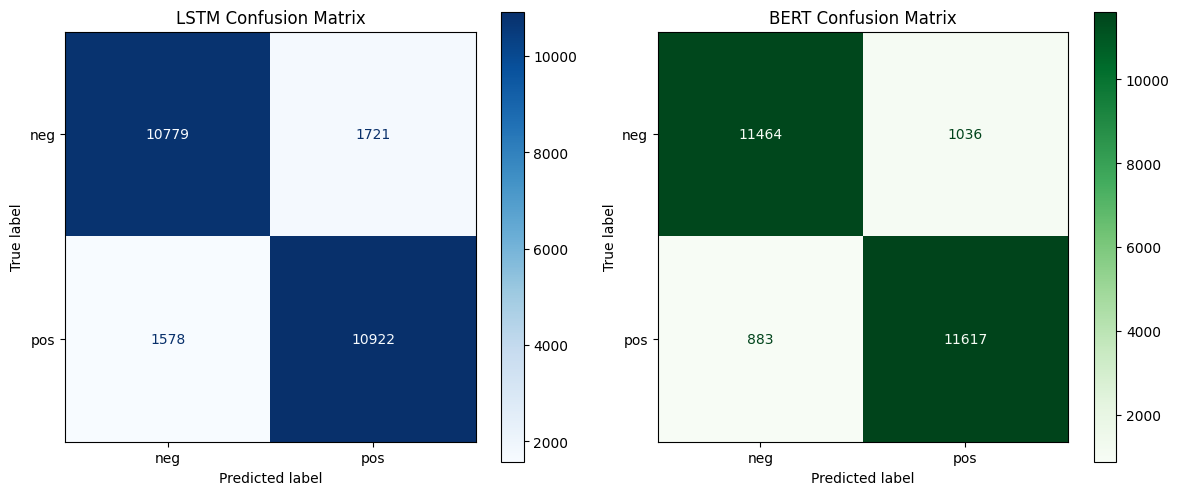

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
disp_l = ConfusionMatrixDisplay(cm_lstm, display_labels=["neg","pos"])
disp_l.plot(ax=axes[0], cmap="Blues")
axes[0].set_title("LSTM Confusion Matrix")

cm_bert = confusion_matrix(y_true_bert, y_pred_bert)
disp_b = ConfusionMatrixDisplay(cm_bert, display_labels=["neg","pos"])
disp_b.plot(ax=axes[1], cmap="Greens")
axes[1].set_title("BERT Confusion Matrix")

plt.tight_layout()
plt.show()

# Task 8: Fine-tuning Transformer Models with Hugging Face

In [ ]:
!pip install --upgrade transformers

In [ ]:
from datasets import load_dataset, ClassLabel
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [ ]:
dataset = load_dataset("ag_news")

MODEL_NAME = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
num_labels = dataset["train"].features["label"].num_classes
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels
)

def tokenize_batch(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)

dataset = dataset.map(tokenize_batch, batched=True)
dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

def compute_metrics(pred):
    labels = pred.label_ids
    preds  = np.argmax(pred.predictions, axis=1)
    acc    = accuracy_score(labels, preds)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    return {"accuracy": acc, "precision": p, "recall": r, "f1": f1}

training_args = TrainingArguments(
    output_dir="./roberta-agnews",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    report_to="none",
    logging_strategy="steps",
    logging_steps=500,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()
metrics = trainer.evaluate()
print(metrics)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-24-808c1d3e0aa5>:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.425900
1000,0.278900
1500,0.259500
2000,0.245600
2500,0.242500
3000,0.261000
3500,0.223500
4000,0.223800
4500,0.212200
5000,0.210200


{'eval_loss': 0.21264654397964478, 'eval_accuracy': 0.9518421052631579, 'eval_precision': 0.9519268190657303, 'eval_recall': 0.9518421052631579, 'eval_f1': 0.9518357361062959, 'eval_runtime': 23.1501, 'eval_samples_per_second': 328.292, 'eval_steps_per_second': 10.281, 'epoch': 3.0}
